In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import sys
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
int_dir = os.path.join(proj_dir,'data','analysis','interim')
src_dir = os.path.join(proj_dir,'src')
fig_dir = os.path.join(proj_dir,'reports','devel','figures')

sys.path.append(src_dir)
%load_ext autoreload
%autoreload 1

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

from roms_ds_tools import make_depth_single_time,make_cartesian_grid_3D_single_time
%aimport roms_ds_tools

from log_progress import log_progress
from unesco import unesco
from visualization.shiftedColorMap import shiftedColorMap
from calc_z import calc_z
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
import make_sose_ds as sose_ds
from regrid import regrid

In [2]:
# Number of temperature and salinity bins
num_bins = 1000
# Bounds on temperature and salinity bins (pre-computed, change if needed)
min_salt = 32.1
max_salt = 35.2
min_temp = -3.5
max_temp = 4

temp_bins = np.linspace(min_temp, max_temp, num=num_bins)
# Calculate centres of temperature bins (for plotting)
temp_centres = 0.5*(temp_bins[:-1] + temp_bins[1:])
# Repeat for salinity
salt_bins = np.linspace(min_salt, max_salt, num=num_bins)
salt_centres = 0.5*(salt_bins[:-1] + salt_bins[1:])

freezing_pt_roms = salt_centres/(-18.48 + 18.48/1e3*salt_centres)
salt_2d, temp_2d = np.meshgrid(salt_centres, temp_centres)

density = unesco(temp_2d, salt_2d, np.zeros(np.shape(temp_centres)))-1000
# Density contours to plot
density_lev = np.arange(26.6, 28.4, 0.2)

# SOSE TS diagram south of 65S

In [7]:
sose_path = os.path.join(data_dir,'preprocessing','external','sose')
sds = sose_ds.make_TS_ds(sose_path,records=np.arange(0,12))
sds = sds.mean('time')

load grid
load temperature


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


In [149]:
lon_2d,lat_2d = np.meshgrid(sds.longitude.values,sds.latitude.values)
mask = np.zeros_like(lat_2d,dtype=int)
mask[lat_2d < -65] = 1

lat_min = lat_2d[mask].min()
lat_max = lat_2d[mask].max()
lon_min = lon_2d[mask].min()
lon_max = lon_2d[mask].max()

temp = sds.temperature.values
salt = sds.salinity.values
depth = sds.depth.values
depth = np.rollaxis(np.tile(depth,(320,2160,1)),-1)
dV = sds.DRC*sds.DXC*sds.DYC

bound_mask = (temp < max_temp) & (temp > min_temp) & \
             (salt > min_salt) & (salt < max_salt)

# Set up 2D arrays of temperature bins x salinity bins to hold average
# depth of water masses, weighted by volume
sose_ts_vals = np.zeros([np.size(temp_centres), np.size(salt_centres)])
# Also arrays to integrate volume
volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])

# Loop over 2D grid boxes
for j in log_progress(np.arange(lon_2d.shape[0])):
    for i in np.arange(lon_2d.shape[1]):
        # Check for land mask
        if mask[j,i]:
            for k in np.arange(sds.depth.size):
                if bound_mask[k,j,i]:
                    # Figure out which bins this falls into
                    temp_index = np.nonzero(temp_bins > temp[k,j,i])[0][0] - 1
                    salt_index = np.nonzero(salt_bins > salt[k,j,i])[0][0] - 1
                    # Integrate depth*dV in this bin
                    sose_ts_vals[temp_index, salt_index] += -depth[k,j,i]*dV[k,j,i]
                    volume[temp_index, salt_index] += dV[k,j,i]

# Mask bins with zero volume
sose_ts_vals = np.ma.masked_where(volume ==0, sose_ts_vals)
volume = np.ma.masked_where(volume ==0, volume)
# Convert depths from integrals to volume-averages
sose_ts_vals /= volume



In [150]:
out_path = os.path.join(int_dir,'ts_vals_sose_65.npy')
sose_ts_vals.dump(out_path)

In [6]:
sose_ts_vals= np.load(os.path.join(int_dir,'ts_vals_sose_65.npy'),allow_pickle=True)

In [10]:
def plot_ts(ts_vals,title,min_salt = 33.2,max_salt = 35, min_temp = -3.5, max_temp = 3.8, save=False):

    max_depth = ts_vals.max()
    bounds = np.linspace(0, max_depth**(1.0/2.5), num=100)**2.5
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    manual_locations = [(33.4, 3.0), (33.65, 3.0), (33.9, 3.0), (34.2, 3.0), (34.45, 3.5), (34.65, 3.25), (34.9, 3.0), (35, 1.5)]
    
    plt.close()
    fig,ax = plt.subplots(figsize=(10,18))

    img = ax.pcolor(salt_centres,temp_centres,ts_vals, norm=norm, vmin=0, vmax=max_depth, cmap='jet')
    ax.plot(salt_centres, freezing_pt_roms, color='black', linestyle='dashed')
    cs = ax.contour(salt_centres, temp_centres, density, density_lev, linestyles='dotted',colors='gray')
    #ax.clabel(cs, inline=1, fontsize=24, color=(0.6,0.6,0.6), fmt='%1.1f', manual=manual_locations)
    ax.clabel(cs, inline=1, fontsize=24, fmt='%1.1f', manual=manual_locations)
    ax.set_xlim([min_salt, max_salt])
    ax.set_ylim([min_temp, max_temp])
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

    ax.set_xlabel('Salinity (psu)',size=24)
    ax.set_ylabel('Temperature ($^{\circ}$C)',size=24)

    ax.set_title(title, size=24)

    
    # Add a colourbar on the right
    #cbaxes = fig.add_axes([0.93, 0.2, 0.02, 0.6])
    cbar = plt.colorbar(img, ax=ax, ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
    cbar.ax.tick_params(labelsize=24)
    cbar.set_label(label='Depth in m',weight='bold',size=24)

    if save:
        plt.savefig(os.path.join(fig_dir,title+'ts_65.png'),transparent=True,dpi=300,bbox_inches = "tight")
    plt.show()

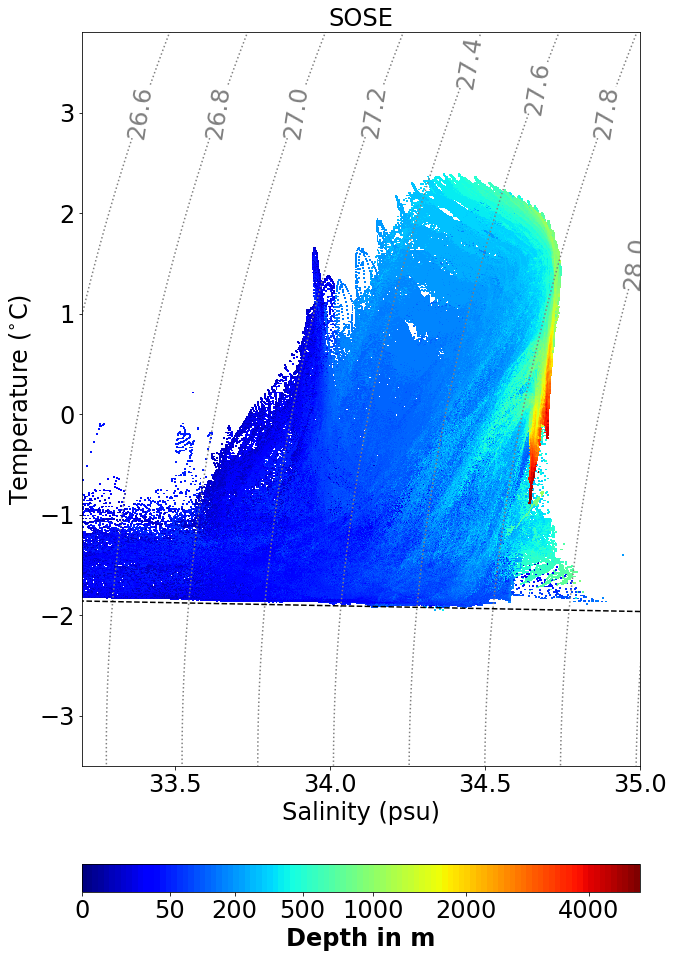

In [50]:
plot_ts(sose_ts_vals,'SOSE',save=True)

# ROMS TS diagrams

## Total Antarctica

In [3]:
grd_path = os.path.join(data_dir,'analysis','interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False
grd.mask_rho[1000:1500,2000:2500] = False

In [4]:
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
zeta_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')
temp = xr.open_dataset(temp_path).temp.isel(ocean_time=0)
salt = xr.open_dataset(salt_path).salt.isel(ocean_time=0)
zeta = xr.open_dataset(zeta_path).zeta.isel(ocean_time=0)

In [9]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:57367 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [10]:
def make_ts_vals(grd,temp,salt,depth,dV,mask):
    
    xi_2d,eta_2d = np.meshgrid(grd.xi_rho.values,grd.eta_rho.values)
    
    eta_min = eta_2d[mask].min()
    eta_max = eta_2d[mask].max()
    xi_min = xi_2d[mask].min()
    xi_max = xi_2d[mask].max()
    
    temp = temp.values
    salt = salt.values
    depth = depth.values
    dV = dV.values

    bound_mask = (temp < max_temp) & (temp > min_temp) & \
                 (salt > min_salt) & (salt < max_salt)

    # Set up 2D arrays of temperature bins x salinity bins to hold average
    # depth of water masses, weighted by volume
    ts_vals = np.zeros([np.size(temp_centres), np.size(salt_centres)])
    # Also arrays to integrate volume
    volume = np.zeros([np.size(temp_centres), np.size(salt_centres)])
    
    # Loop over 2D grid boxes
    for j in log_progress(np.arange(eta_min,eta_max+1,dtype=int)):
        for i in np.arange(xi_min,xi_max+1,dtype=int):
            # Check for land mask
            if mask[j,i]:
                for k in np.arange(grd.s_rho.size):
                    if bound_mask[k,j,i]:
                        # Figure out which bins this falls into
                        temp_index = np.nonzero(temp_bins > temp[k,j,i])[0][0] - 1
                        salt_index = np.nonzero(salt_bins > salt[k,j,i])[0][0] - 1
                        # Integrate depth*dV in this bin
                        ts_vals[temp_index, salt_index] += -depth[k,j,i]*dV[k,j,i]
                        volume[temp_index, salt_index] += dV[k,j,i]

    # Mask bins with zero volume
    ts_vals = np.ma.masked_where(volume ==0, ts_vals)
    volume = np.ma.masked_where(volume ==0, volume)
    # Convert depths from integrals to volume-averages
    ts_vals /= volume

    return ts_vals

In [12]:
theta_s = 7
theta_b = 8
hc = 250
N = 31
Vstretching = 4

depths,s,C = calc_z(grd.h.values,grd.zice.values,theta_s,theta_b,hc,N,zeta.values,Vstretching)

grd = grd.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

In [ ]:
mask = (grd.mask_rho == 1) & (grd.lat_rho < -65)
ts_vals_65 = make_ts_vals(grd,temp,salt,grd.depth,grd.dV,mask)
out_path = os.path.join(int_dir,'ts_vals2_65.npy')
ts_vals_65.dump(out_path)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [8]:
ts_vals_65 = np.load(os.path.join(int_dir,'ts_vals2_65.npy'),allow_pickle=True)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  # This is added back by InteractiveShellApp.init_path()


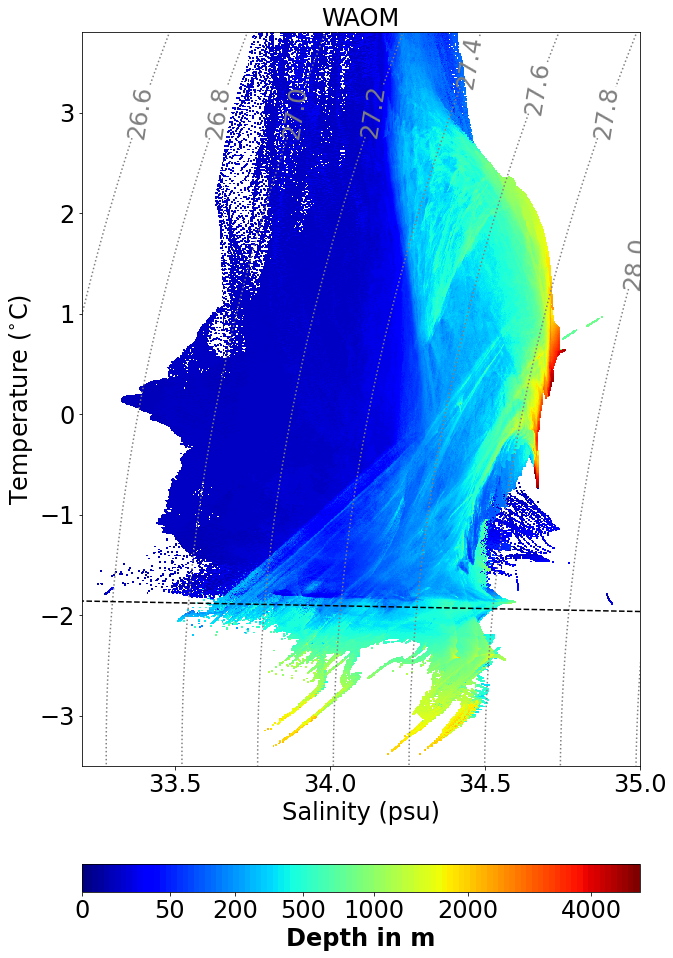

In [11]:
plot_ts(ts_vals_65,'WAOM',save=True)

# Plotting both with labels

In [ ]:
def ax_ts(ax,ts_vals,title,min_salt = 33.2,max_salt = 35.1, min_temp = -3.0, max_temp = 3.8, max_depth= 5900, save=False):

    bounds = np.linspace(0, max_depth**(1.0/2.5), num=100)**2.5
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    manual_locations = [(33.4, 3.0), (33.65, 3.0), (33.9, 3.0), (34.2, 3.0), (34.45, 3.5), (34.65, 3.25), (34.9, 3.0), (35, 1.5)]

    img = ax.pcolor(salt_centres,temp_centres,ts_vals, norm=norm, vmin=0, vmax=max_depth, cmap='jet')
    ax.plot(salt_centres, freezing_pt_roms, color='black', linestyle='dashed')
    cs = ax.contour(salt_centres, temp_centres, density, density_lev, linestyles='dotted',colors='gray')
    ax.clabel(cs, inline=1, fmt='%1.1f', manual=manual_locations)#, colors=(0.6,0.6,0.6)
    ax.set_xlim([min_salt, max_salt])
    ax.set_ylim([min_temp, max_temp])
    #ax.tick_params(axis='x', labelsize=24)
    #ax.tick_params(axis='y', labelsize=24)

    #ax.set_xlabel('Salinity (psu)')
    #ax.set_ylabel('Temperature ($^{\circ}$C)')

    ax.set_title(title, size=12, weight='bold')

    
    # Add a colourbar on the right
    #cbaxes = fig.add_axes([0.93, 0.2, 0.02, 0.6])
    #cbar = plt.colorbar(img, ax=ax, ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
    #cbar.ax.tick_params(labelsize=24)
    #cbar.set_label(label='Depth in m',weight='bold',size=24)

    return ax,img

def wm_label(ax,salt,temp,label):
    ax.text( salt, temp,label, ha='center', va='center',transform=ax.transData )
    return ax

In [ ]:
import string
fig,axes = plt.subplots(ncols=2,figsize = (8.29, 5))

ax1,ax2 = axes.flatten()

ax1,img = ax_ts(ax1,woa_ts,'WAOM')
ax2,img = ax_ts(ax2,ecco_ts,'SOSE')

ax1.set_ylabel('Temperature ($^{\circ}$C)')

ax1 = wm_label(ax1, 34.7, 1.75, 'AABW')
ax1 = wm_label(ax1, 34.4, 1.0, 'CDW')
ax1 = wm_label(ax1, 34.3, -0.75, 'MCDW')
ax1 = wm_label(ax1, 34.85, 0. , 'RSBW/WSBW')
#ax1 = wm_label(ax1, 34.85, -0.75 , 'WSBW')
ax1 = wm_label(ax1, 33.5, -2.5 , 'ISW')
ax1 = wm_label(ax1, 33.75, -0.5 , 'AASW')
ax1 = wm_label(ax1, 34.1, -1.75 , 'LSSW')
ax1 = wm_label(ax1, 34.7, -1.8 , 'HSSW')
                            
n=0
for ax in [ax1,ax2]:
    ax.set_xlabel('Salinity (psu)')    
    ax.text(-0.00, 1.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1    
    

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
cbar.set_label(label='Depth in m',weight='bold')

#plt.subplots_adjust(wspace=0.1)

out_path = os.path.join(fig_dir,'TS_WAOM_SOSE_65.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

## SST SOSE vs ROMS

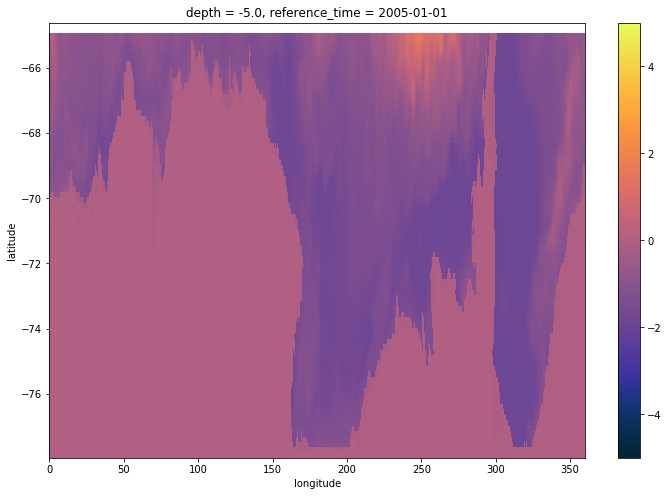

In [11]:
sds.sel(depth=-5).temperature.where(sds.latitude<-65)[:80].plot(size=8,cmap=ocm.thermal,vmin=-5,vmax=5)

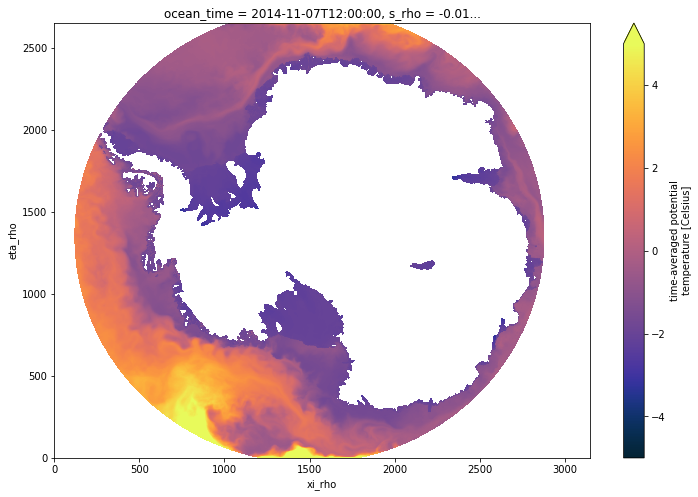

In [9]:
temp.isel(s_rho=30).where(grd.lat_rho<-65).plot(size=8,cmap=ocm.thermal,vmin=-5,vmax=5)

## For each sector

In [10]:
ts_vals_sector={}
for sector_name,sector_mask in mask_shelf.items():
    print('Processing '+ sector_name)
    print('Generating mask ...')
    mask = (grd.mask_rho == 1) & (sector_mask == 1) & (grd.lat_rho < -65)
    print('done! \n Binning TS values ...')
    ts_vals_sector[sector_name] = make_ts_vals(grd,temp,salt,grd.z,grd.dV,mask)

Processing Total Antarctica
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing Western East Antarctica
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing Amery/Prydz Bay
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing Sabrina Coast/Aurora subglacial basin
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing George V Coast/Wilkes subglacial basin
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing Ross Sea
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing Amundsen Sea
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing Bellingshausen Sea
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


Processing Weddell Sea
Generating mask ...
done! 
 Binning TS values ...


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


NameError: name 'ts_vals' is not defined

In [11]:
dict_out_path = os.path.join(int_dir,'ts_vals2_sec_65.npy')
np.save(dict_out_path,ts_vals_sector)

In [17]:
ts_vals = np.load(os.path.join(int_dir,'ts_vals2_sec_65.npy'),allow_pickle=True).item()

In [18]:
ts_vals["Sabrina Coast"] = ts_vals.pop('Sabrina Coast/Aurora subglacial basin')
ts_vals['George V Coast'] = ts_vals.pop('George V Coast/Wilkes subglacial basin')
ts_vals['Prydz Bay'] = ts_vals.pop('Amery/Prydz Bay')

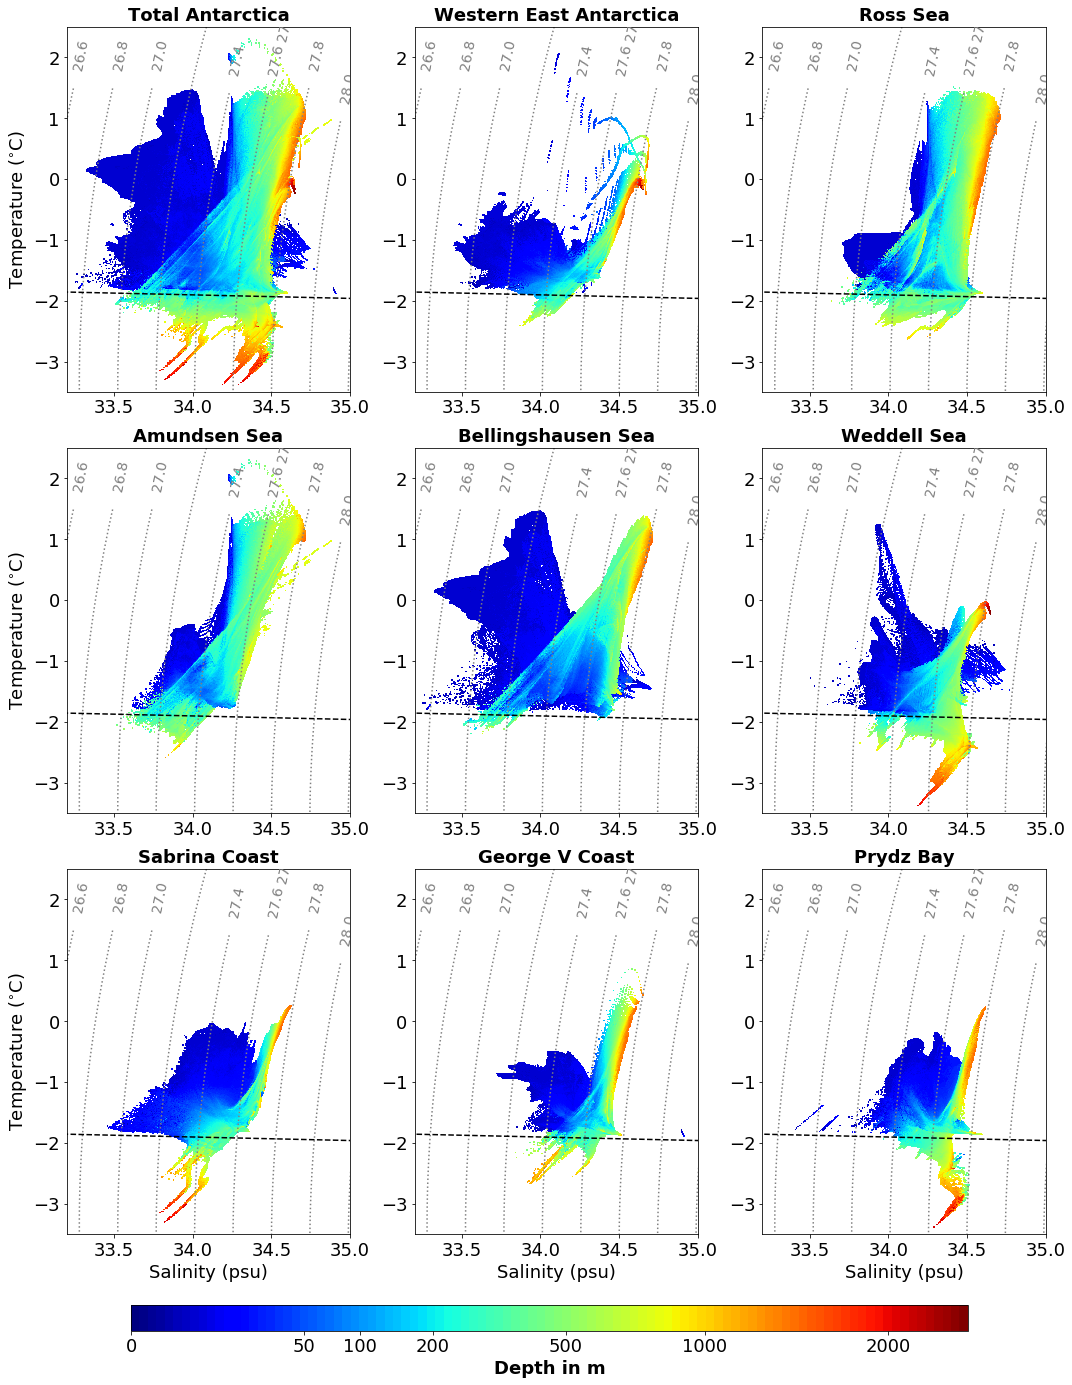

In [32]:
# Bounds to actually plot
max_depth = ts_vals['Total Antarctica'].max()
min_salt = 33.2
max_salt = 35
min_temp = -3.5
max_temp = 2.5
bounds = np.linspace(0, max_depth**(1.0/2.5), num=100)**2.5
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
manual_locations = [(33.4, 2.0), (33.65, 2.0), (33.9, 2.0), (34.2, 2.0), (34.45, 2.0), (34.65, 2.25), (34.9, 2.0), (35, 1.5)]

plt.close()
fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(15,18))

for ax,(sec_name,sec_values) in log_progress(zip(axes.flatten(),ts_vals.items()),every=2):
    img = ax.pcolor(salt_centres,temp_centres,sec_values, norm=norm, vmin=0, vmax=max_depth, cmap='jet')
    ax.plot(salt_centres, freezing_pt_roms, color='black', linestyle='dashed')
    cs = ax.contour(salt_centres, temp_centres, density, density_lev, linestyles='dotted',colors='gray')
    ax.clabel(cs, inline=1, fontsize=14, color=(0.6,0.6,0.6), fmt='%1.1f', manual=manual_locations)
    ax.set_xlim([min_salt, max_salt])
    ax.set_ylim([min_temp, max_temp])
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_title(sec_name,fontsize=18,weight='bold')
    
for ax in axes.flatten()[6:]:
    ax.set_xlabel('Salinity (psu)',fontsize=18)
for ax in axes.flatten()[[0,3,6]]:
    ax.set_ylabel(r'Temperature ($^{\circ}$C)',fontsize=18)
    
#plt.suptitle('Water masses in the ice shelf cavities, 2007 average', fontsize=24)

# Add a colourbar on the right
p0 = axes.flatten()[6].get_position().get_points().flatten()
p1 = axes.flatten()[8].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.03, p1[2]-p0[0], 0.02])
cbar = plt.colorbar(img, cax=ax_cbar,ticks=[0,50,100,200,500,1000,2000],orientation="horizontal")
cbar.set_label('Depth in m',weight = 'bold',size=18)
cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'ts_sector_shelf.png'),transparent=True,dpi=200,bbox_inches='tight')
plt.show()

## for certain depth ranges

In [17]:
ts_vals_mask = {}
for sec_name,sec_vals in ts_vals.items():
    ts_vals_mask[sec_name] = np.zeros_like(sec_vals)
    ts_vals_mask[sec_name][sec_vals<=200]=1
    ts_vals_mask[sec_name][(sec_vals<=400)&(sec_vals>200)]=2
    ts_vals_mask[sec_name][sec_vals>400]=3
    ts_vals_mask[sec_name] =  np.ma.masked_array(ts_vals_mask[sec_name],sec_vals.mask)

KeyError: 'Bellingshausen'

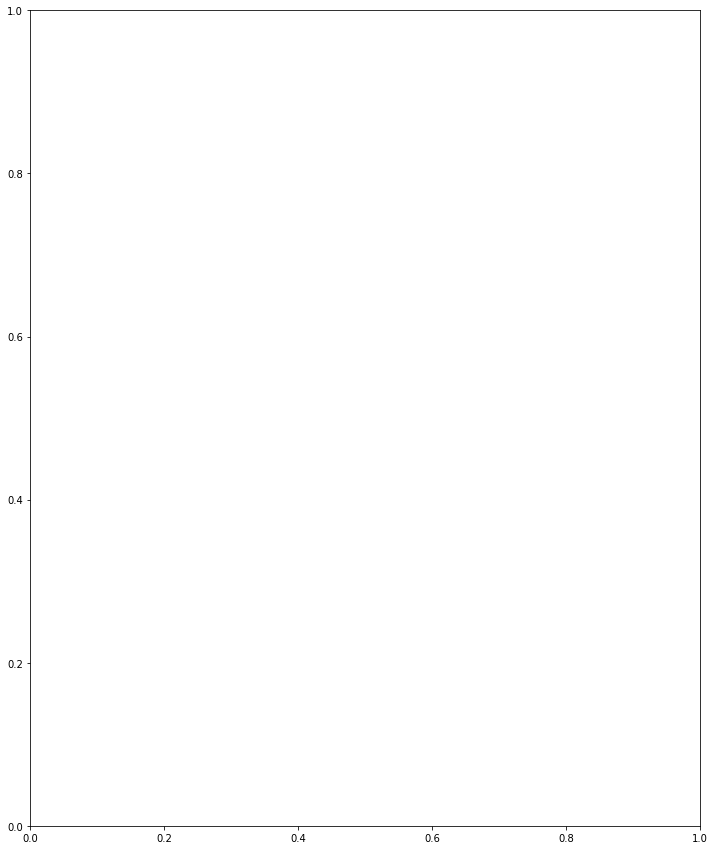

In [11]:
plt.close()
fig,ax = plt.subplots(figsize=(12,15))
#ts_vals_mask['Bellingshausen'].plot()
img = ax.contourf(salt_centres,temp_centres,ts_vals_mask['Bellingshausen'],levels=[0,1,2,3],colors=['b','b','orange'])
cbaxes = fig.add_axes([0.93, 0.2, 0.02, 0.6])
cbar = plt.colorbar(img, cax=cbaxes, ticks=[0.5,1.5,2.5])
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_yticklabels(['shallow','mid','deep'])
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


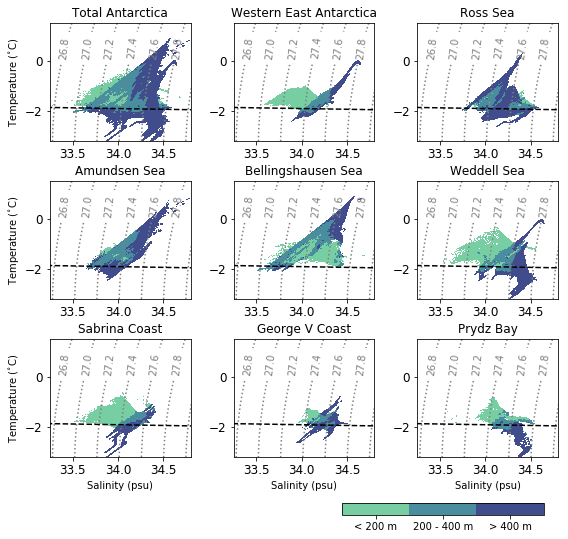

In [63]:
cmap=ocm.deep
colors=(cmap(0.25),cmap(0.5),cmap(0.75))
# Bounds to actually plot
max_depth = ts_vals['Total Antarctica'].max()
min_salt_plot = 33.25
max_salt_plot = 34.8
min_temp_plot = -3.2
max_temp_plot = 1.5
#bounds = np.linspace(0, max_depth**(1.0/2.5), num=100)**2.5
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
manual_locations = [(33.4, 0.5), (33.65, 0.5), (33.9, 0.5), (34.2, 0.5), (34.45, 0.5), (34.65, 0.5), (34.9, 0.5), (35, 0.5)]

plt.close()
fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(8,8))

for ax,(sec_name,sec_values) in log_progress(zip(axes.flatten(),ts_vals_mask.items()),every=2):
    img = ax.contourf(salt_centres,temp_centres,sec_values,levels=[0,1,2,3],colors=colors)
    ax.plot(salt_centres, freezing_pt_roms, color='black', linestyle='dashed')
    cs = ax.contour(salt_centres, temp_centres, density, density_lev, linestyles='dotted',colors='gray')
    ax.clabel(cs, inline=1, color=(0.6,0.6,0.6), fmt='%1.1f', manual=manual_locations)#, fontsize=14)
    ax.set_xlim([min_salt_plot, max_salt_plot])
    ax.set_ylim([min_temp_plot, max_temp_plot])
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_title(sec_name)
    
for ax in axes.flatten()[6:]:
    ax.set_xlabel('Salinity (psu)')
for ax in axes.flatten()[[0,3,6]]:
    ax.set_ylabel(r'Temperature ($^{\circ}$C)')
    
#plt.suptitle('Water masses in the ice shelf cavities, 2007 average', fontsize=24)

#cbaxes = fig.add_axes([0.93, 0.2, 0.02, 0.6])
cbaxes = fig.add_axes([0.6, 0.1, 0.35, 0.02])
cbar = plt.colorbar(img, cax=cbaxes, ticks=[0.5,1.5,2.5],orientation='horizontal')
#cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xticklabels(['< 200 m','200 - 400 m','> 400 m'])

plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.savefig(os.path.join(fig_dir,'ts_cavities_shallow2.png'),transparent=True,dpi=300)
plt.show()